In [20]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
import torch  
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cross_entropy
import torch.nn as nn

In [4]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [5]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

100%|██████████| 9912422/9912422 [00:03<00:00, 2610895.95it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2411908.53it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2031327.88it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


Для наших целей мы вытяним входные данные ($ x $), чтобы наши данные во время обучения имели формы:

- `x_batch` размера `(batch_size, 784)`
- `y_batch` размера `(batch_size)`

In [6]:
batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
features = 784
classes = 10

W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[-0.0088, -0.0323,  0.0187,  ..., -0.0305,  0.0143, -0.0278],
        [ 0.0006,  0.0049,  0.0017,  ..., -0.0046, -0.0053,  0.0296],
        [-0.0092,  0.0321, -0.0181,  ..., -0.0244,  0.0332,  0.0163],
        ...,
        [ 0.0282, -0.0216, -0.0334,  ..., -0.0062, -0.0293,  0.0166],
        [ 0.0210,  0.0207, -0.0138,  ..., -0.0226, -0.0174,  0.0281],
        [ 0.0348,  0.0229, -0.0248,  ..., -0.0172,  0.0235, -0.0317]],
       requires_grad=True)

In [11]:
epochs = 3
lr=1e-2
history = []

for i in range(epochs):
  for x_batch, y_batch in train_loader:
    
    # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.reshape(x_batch.shape[0], -1)

    # вычисляем функцию потерь (log loss, также известная как кросс-энтропия)
    logits = x_batch @ W
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    
    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())

    # вычисляем градиенты
    loss.backward()

    # делаем шаг градиентного спуска
    grad = W.grad
    with torch.no_grad():
      W -= lr * grad
    W.grad.zero_()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.2000042051076889
2,	 loss: 0.1433311402797699
3,	 loss: 0.12278035283088684


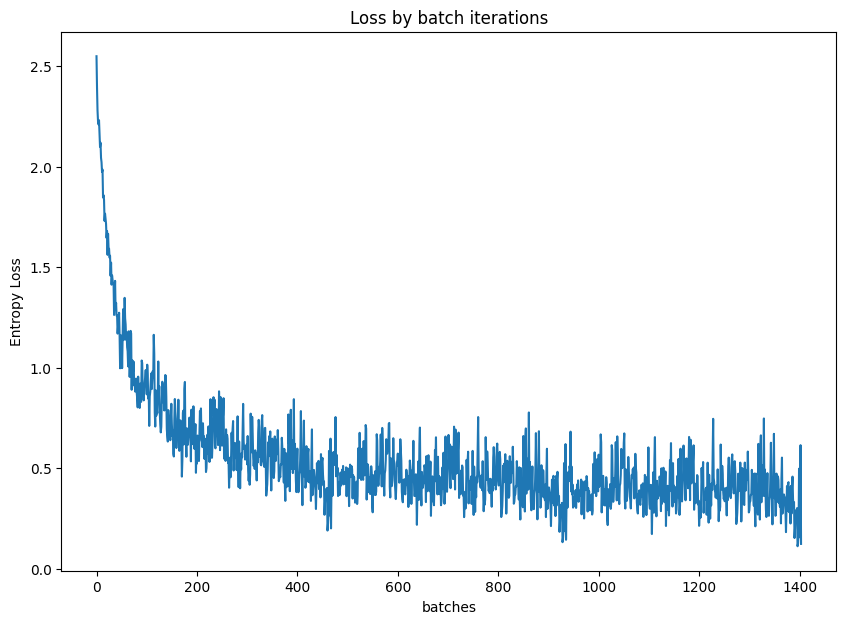

In [14]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [15]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  preds = torch.argmax(x_batch @ W, dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.9


In [21]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
  
  #НЕ НУЖНЕН СОФТМАКС
)

In [22]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [24]:
epochs = 3
history = []
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  

for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # 1. # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
    logits = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    # 4. вычисляем градиенты
    optimizer.zero_grad()
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

AssertionError: Torch not compiled with CUDA enabled